In [1]:
import Module as md
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from pytorch_grad_cam import GradCAM, AblationCAM, EigenCAM, ScoreCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import random
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneGroupOut
import copy
import pickle

from ConLoss import SupConLoss
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def seed_it(seed):
    random.seed(seed) 
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = True 
    torch.backends.cudnn.enabled = True  
    torch.manual_seed(seed)
seed = 456
seed_it(seed)
kf = KFold(n_splits=10, shuffle=True, random_state=123)

In [4]:
'''
load data
'''
import mne
with open('.//data_all.pkl', 'rb') as file:
    data_all = pickle.load(file)
eeg_data = data_all['eeg_data']
emo_label = data_all['emo_label']
task_label = data_all['task_label']
group = data_all['group']

eeg_data.shape, emo_label.shape, task_label.shape, group.shape

(torch.Size([1363, 1, 62, 425]),
 torch.Size([1363]),
 torch.Size([1363]),
 torch.Size([1363]))

In [5]:
'''
Obtain EEG channel information
'''
def file_filter(file):
    if file[-4:] in ['.set']:
        return True
    else:
        return False

dig_montage = mne.channels.read_custom_montage(r'.\info\chan_loca.loc')
data_dir = r'.\data\epoch_emotion' 
data_list = list(filter(file_filter, os.listdir(data_dir)))
group = np.empty(shape=[0, 1])
for i, now in enumerate(data_list):
    list_now = os.path.join(data_dir, now)

    eeg_data_mne = mne.read_epochs_eeglab(list_now, uint16_codec='latin1', verbose=-1)
eeg_data_mne.set_montage(dig_montage)

Extracting parameters from E:\data\EEG_1\data_preprocessing_2\epoch_emotion\1082802.set...
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from E:\data\EEG_1\data_preprocessing_2\epoch_emotion\1082901.set...
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from E:\data\EEG_1\data_preprocessing_2\epoch_emotion\1083003.set...
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from E:\data\EEG_1\data_preprocessing_2\epoch_emotion\1083103.set...
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from E:\data\EEG_1\data_preprocessing_2\epoch_emotion\1090101.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection ite

Number of events,50
Events,33: 50
Time range,-0.200 – 1.496 sec
Baseline,off


In [6]:
def cam_pic(load_path, k_load, target_layers, CAM_method, aug_smooth, eigen_smooth, num_cls=0, target=False):
    device = torch.device("cuda")
    state_dict = torch.load(load_path)
    model.load_state_dict(state_dict['model'])
    model.to(device)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for k, (train, test) in enumerate(kf.split(eeg_data, emo_label)):
        if k == k_load:
            model.eval()
            input_tensor = eeg_data[test].to(device)
            if target==True:
                targets = [ClassifierOutputTarget(num_cls)] * input_tensor.shape[0]
            
            target_layers = [target_layers]

            if CAM_method == 'GradCAM' and target==True:
                with GradCAM(model=model, use_cuda='cuda', target_layers=target_layers) as cam:
                    cam.batch_size = input_tensor.shape[0]
                    grayscale_cams = cam(input_tensor=input_tensor, targets=targets, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
                    img = np.zeros((62, 425, 3))
                    
            if CAM_method == 'GradCAM' and target==False:
                with GradCAM(model=model, use_cuda='cuda', target_layers=target_layers) as cam:
                    cam.batch_size = input_tensor.shape[0]
                    grayscale_cams = cam(input_tensor=input_tensor, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
                    img = np.zeros((62, 425, 3))

            if CAM_method == 'EigenCAM':
                with EigenCAM(model=model, use_cuda='cuda', target_layers=target_layers) as cam:
                    cam.batch_size = input_tensor.shape[0]
                    grayscale_cams = cam(input_tensor=input_tensor, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
                    img = np.zeros((62, 425, 3))
                    
                   
            if CAM_method == 'ScoreCAM':
                with ScoreCAM(model=model, use_cuda='cuda', target_layers=target_layers) as cam:
                    cam.batch_size = input_tensor.shape[0]
                    grayscale_cams = cam(input_tensor=input_tensor, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
                    img = np.zeros((62, 425, 3))
                  
            fig, ax = plt.subplots(figsize=(12, 5))
            
            im = ax.pcolormesh(np.mean(grayscale_cams, axis=0), cmap='jet',)            
            
            cbar = fig.colorbar(im, ax=ax)
            ax.invert_yaxis()
       
            y_tick_pos = np.arange(0, 62, 2)
            ax.set_yticks(y_tick_pos)
            y_tick_labels = [eeg_data_mne.ch_names[chan_locs] for chan_locs in y_tick_pos]
            ax.set_yticklabels(y_tick_labels)
          
            x_tick_pos = np.arange(0, 425.1, 25)
            ax.set_xticks(x_tick_pos)
           
            x_tick_labels = ['-200']  + [''] + ['0'] + [''] * 4 + ['500'] + [''] * 4 + ['1000'] + [''] * 4 + ['1500'] 
            ax.set_xticklabels(x_tick_labels)
            ax.set_xlabel('Time (ms)')

            
            fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw=dict(width_ratios=[6, 0.3]))
            im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False
                                          , vmin=np.min(np.mean(grayscale_cams, axis=0))
                        
                            )

            clb = fig.colorbar(im, cax=cbar_ax, ax=ax)


In [7]:
from pytorch_grad_cam import GradCAM, AblationCAM, EigenCAM, ScoreCAM, EigenGradCAM, GradCAMPlusPlus, LayerCAM
def cam_pic_avg(load_path, target_layer, aug_smooth=True, eigen_smooth=False, num_cls=0, target=False):
    device = torch.device("cuda")
    Target_Layer = [target_layer]
    for k, (train, test) in enumerate(kf.split(eeg_data, emo_label)):
        pkl_name ='KFold=%s.pkl' % (k+1)  
        state_dict = torch.load(os.path.join(load_path, pkl_name))
        model.load_state_dict(state_dict['model'])
        model.eval()
        input_tensor = eeg_data[test].to(device)
       
        with GradCAM(model=model, use_cuda='cuda', target_layers=Target_Layer) as cam:
            grayscale_cams_now = cam(input_tensor=input_tensor, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
        if k==0:
            grayscale_cams_all = grayscale_cams_now
        else:
            grayscale_cams_all = np.concatenate([grayscale_cams_all, grayscale_cams_now], axis=0)
        if k==9:
            fig, ax = plt.subplots(figsize=(12, 5))
           
            im = ax.pcolormesh(np.mean(grayscale_cams_all, axis=0), cmap='jet',)            

            cbar = fig.colorbar(im, ax=ax)
            ax.invert_yaxis()
       
            y_tick_pos = np.arange(0, 62, 2)
            ax.set_yticks(y_tick_pos)
            y_tick_labels = [eeg_data_mne.ch_names[chan_locs] for chan_locs in y_tick_pos]
            ax.set_yticklabels(y_tick_labels)
            
            x_tick_pos = np.arange(0, 425.1, 25)
            ax.set_xticks(x_tick_pos)
           
            x_tick_labels = ['-200']  + [''] + ['0'] + [''] * 4 + ['500'] + [''] * 4 + ['1000'] + [''] * 4 + ['1500'] 
            ax.set_xticklabels(x_tick_labels)
            ax.set_xlabel('Time (ms)')
         
            fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw=dict(width_ratios=[6, 0.3]))
            im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams_all, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False
                                      , vmin=np.min(np.mean(grayscale_cams_all, axis=0))
                                     
                        )

            clb = fig.colorbar(im, cax=cbar_ax, ax=ax)
      

In [33]:
load_path = 'E:\code\EEG_1\model\model_parameter_new\model3_cls=1_emo=0.5_task=0.5_mi=0.1_dim=128_temp=1_GRL=False_new'
aug_smooth=False
eigen_smooth=False
dim = 128

C:\Users\pc\AppData\Local\Temp\ipykernel_18388\1135501889.py:45: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams_all, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False


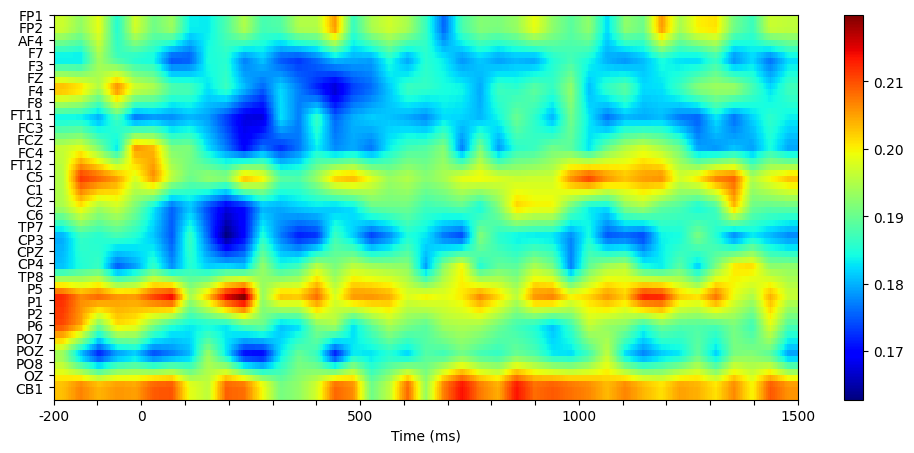

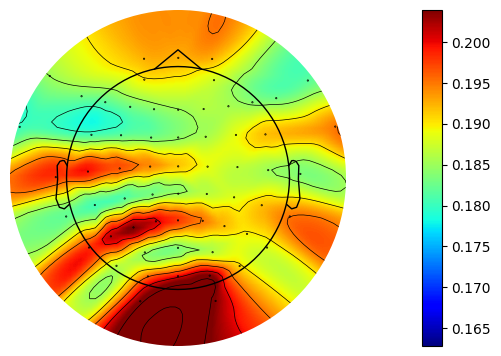

In [44]:
model = md.model_3(token_dim=dim, out_put='emo', device='cuda:0', GRL=False)
cam_pic_avg(load_path=load_path,
        target_layer=model.emo_encoder.block_1[9],
        aug_smooth=aug_smooth,
        eigen_smooth=eigen_smooth,
        target=False,
       )

C:\Users\pc\AppData\Local\Temp\ipykernel_18388\1135501889.py:45: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams_all, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False


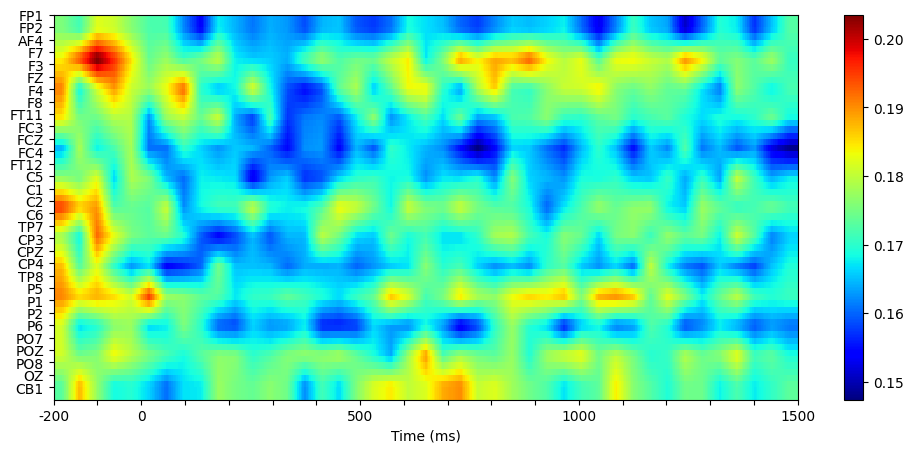

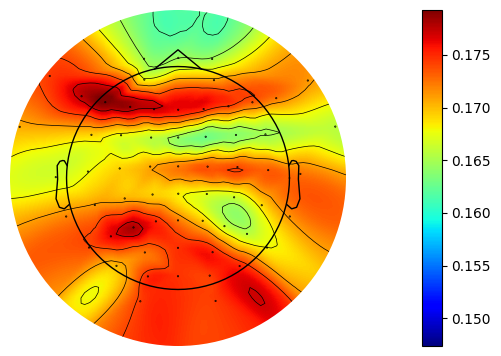

In [45]:
model = md.model_3(token_dim=dim, out_put='task', device='cuda:0', GRL=False)
b = cam_pic_avg(load_path=load_path,

        target_layer=model.task_encoder.block_1[9],
        aug_smooth=aug_smooth,
        eigen_smooth=eigen_smooth,
        target=False,
       )

C:\Users\pc\AppData\Local\Temp\ipykernel_18388\1135501889.py:45: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams_all, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False


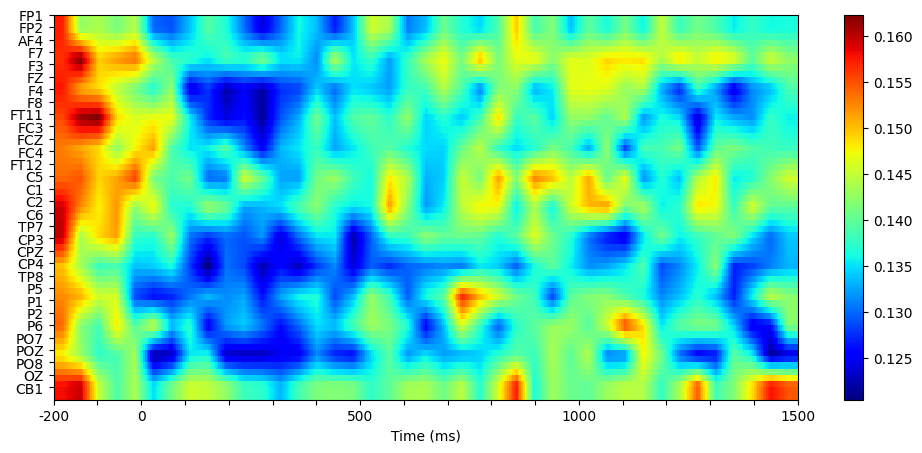

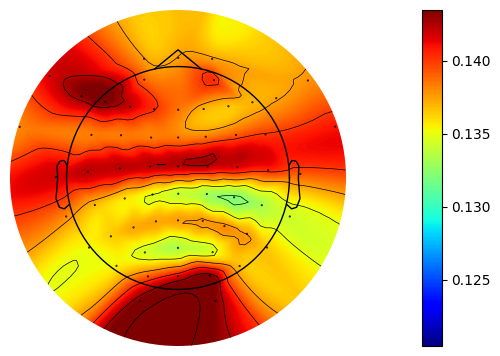

In [58]:
model = md.model_3(token_dim=dim, out_put='mi', device='cuda:0', GRL=False)
cam_pic_avg(load_path=load_path,
        target_layer=model.emo_encoder.block_1[9],
        aug_smooth=aug_smooth,
        eigen_smooth=eigen_smooth,
        target=False,
       )

C:\Users\pc\AppData\Local\Temp\ipykernel_18388\1135501889.py:45: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  im, cm = mne.viz.plot_topomap(np.mean(np.mean(grayscale_cams_all, axis=0), axis=1), eeg_data_mne.info, cmap='jet', axes=ax , show=False


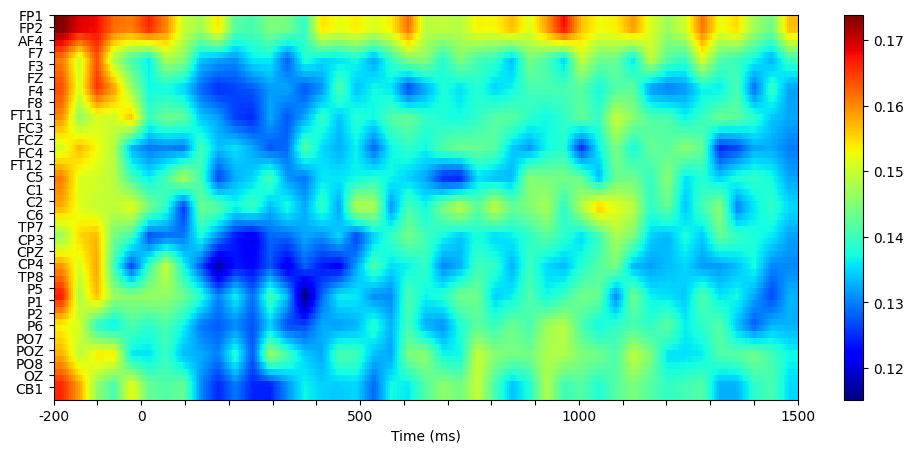

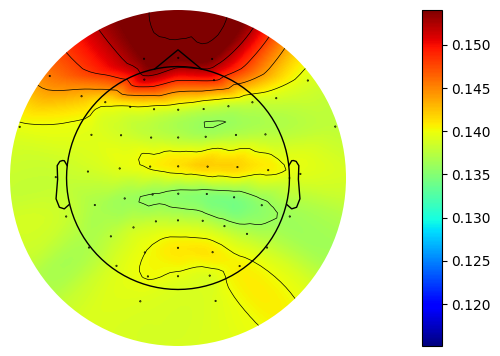

In [49]:
model = md.model_3(token_dim=dim, out_put='mi', device='cuda:0', GRL=False)
cam_pic_avg(load_path=load_path,
        target_layer=model.task_encoder.block_1[9],
        aug_smooth=aug_smooth,
        eigen_smooth=eigen_smooth,
        target=False,
       )